In [ ]:
import os
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import time

!pip install pmdarima --quiet

# 1) Download Dataset
import kagglehub
path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")
print("Path to dataset files:", path)

# 2) Function detect file
def find_transactions_file(base_path):
    CAND = ["Transactions.csv", "transactions.csv", "TRANSACTIONS.csv", "Transactions.CSV"]

    for f in CAND:
        fp = os.path.join(base_path, f)
        if os.path.exists(fp):
            return fp

    for root, dirs, files in os.walk(base_path):
        for f in files:
            if "transaction" in f.lower():
                return os.path.join(root, f)

    raise FileNotFoundError(f"transactions file not found in {base_path}")

# 3) Locate CSV
tx_file = find_transactions_file(path)
print("Using file:", tx_file)

# 4) Load file
tx = pd.read_csv(tx_file, low_memory=False)
print("Raw transactions shape:", tx.shape)
print("Columns:", tx.columns.tolist())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.8 MB/s eta 0:00:00
Using Colab cache for faster access to the 'global-fashion-retail-stores-dataset' dataset.
Path to dataset files: /kaggle/input/global-fashion-retail-stores-dataset
Using file: /kaggle/input/global-fashion-retail-stores-dataset/transactions.csv
Raw transactions shape: (6416827, 19)
Columns: ['Invoice ID', 'Line', 'Customer ID', 'Product ID', 'Size', 'Color', 'Unit Price', 'Quantity', 'Date', 'Discount', 'Line Total', 'Store ID', 'Employee ID', 'Currency', 'Currency Symbol', 'SKU', 'Transaction Type', 'Payment Method', 'Invoice Total']


In [ ]:
import pandas as pd

tx.columns = tx.columns.str.strip()
tx.rename(columns=lambda x: x.replace('\ufeff', ''), inplace=True)

if 'Date' not in tx.columns:
    raise KeyError("Không tìm thấy cột 'Date'. Cột hiện có: " + ", ".join(tx.columns))

tx['Date'] = pd.to_datetime(tx['Date'], errors='coerce')

tx['Revenue_Local'] = pd.to_numeric(tx['Line Total'], errors='coerce').fillna(0)

tx['Revenue_USD'] = tx['Revenue_Local']

negatives = tx[tx['Revenue_Local'] < 0]
print(f"Số giao dịch âm: {len(negatives)}")
if len(negatives) > 0:
    print(negatives.head())

tx = tx.set_index('Date')
daily = (
    tx.groupby("Date")["Revenue_USD"]
      .sum()
      .asfreq("D")
      .fillna(0)
)

print(daily.head(10))


Số giao dịch âm: 339627
              Invoice ID  Line  Customer ID  Product ID Size    Color  \
15   RET-US-001-03558764     1         1968        1208    M   SILVER   
16   RET-US-001-03558764     2         1968        2639    M    WHITE   
31   RET-US-001-03558763     1         8286        1395    M      NaN   
40   RET-US-001-03558767     1        14906        2924  XXL  NEUTRAL   
103  RET-US-001-03558799     1        21979         377    M    LILAC   

     Unit Price  Quantity       Date  Discount  ...  Store ID  Employee ID  \
15         75.0         1 2023-01-01       0.0  ...         1            9   
16         45.5         1 2023-01-01       0.0  ...         1            9   
31         95.5         1 2023-01-01       0.0  ...         1            6   
40         54.0         1 2023-01-01       0.0  ...         1           13   
103        42.0         1 2023-01-01       0.0  ...         1            7   

     Currency Currency Symbol                   SKU Transaction Type

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Validation metrics: {'MAE': 617745.5409165364, 'RMSE': np.float64(807647.3787777096), 'sMAPE': np.float64(58.2390755605658)}
Test metrics: {'MAE': 321602.5306100366, 'RMSE': np.float64(396235.759079787), 'sMAPE': np.float64(47.566652906977886)}
Forecast 30 days:
2025-03-19    8.357260e+05
2025-03-20    1.213428e+06
2025-03-21    1.209069e+06
2025-03-22    9.071209e+05
2025-03-23    9.030777e+05
Freq: D, dtype: float64


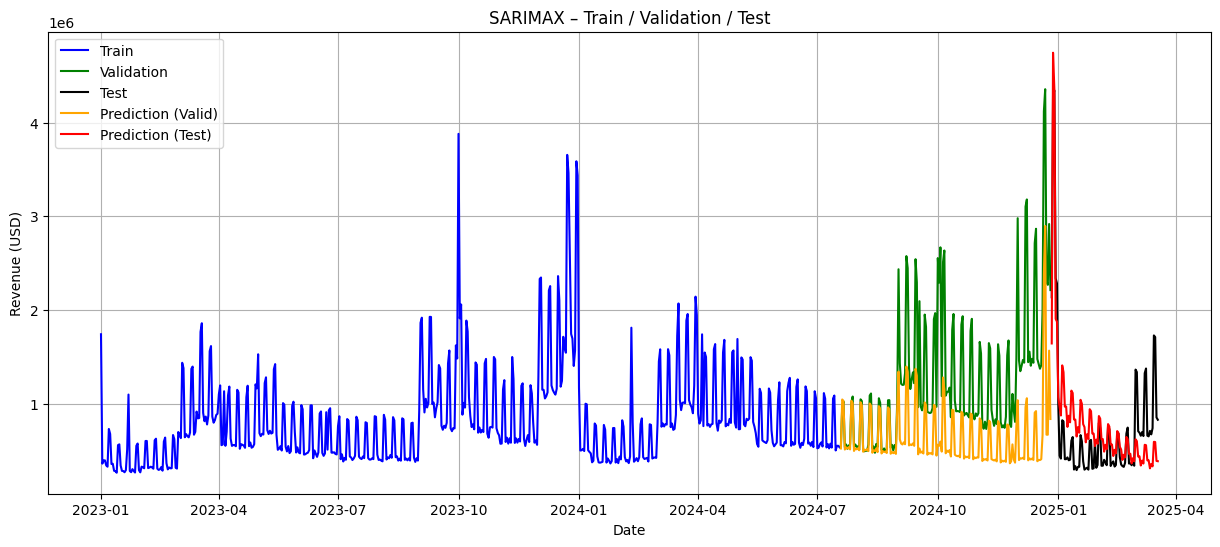

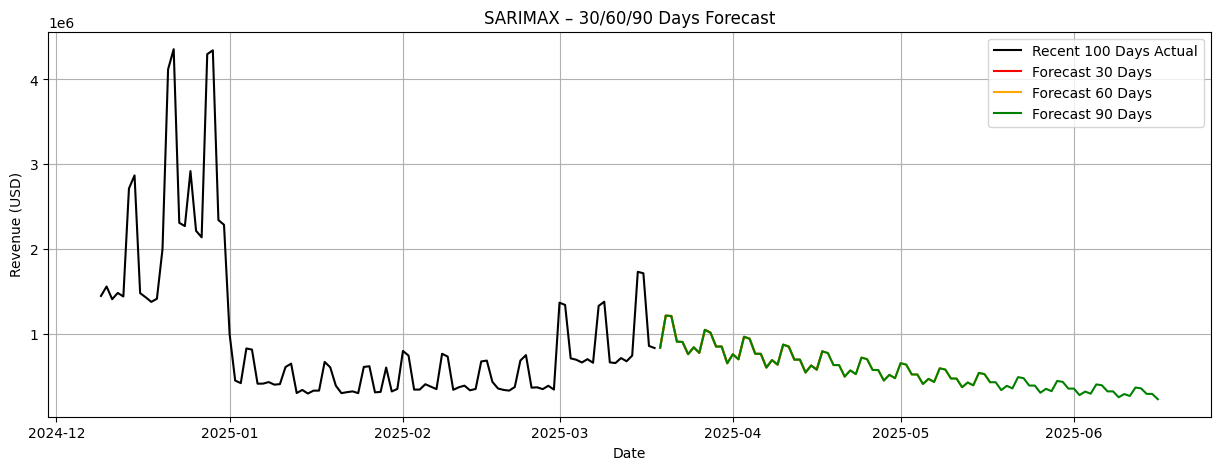

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# --- Dữ liệu đã set index 'Date' ---
ts = tx['Revenue_USD'].resample('D').sum().fillna(0)

# --- Metrics sMAPE ---
def sMAPE(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denom)

# --- Tạo exogenous variables ---
tx['Promotion'] = np.random.randint(0,2,size=len(tx))
tx['Holiday']   = np.random.randint(0,2,size=len(tx))

exog = tx[['Promotion','Holiday']].resample('D').sum().fillna(0)

# --- Log-transform Revenue ---
ts_log = np.log1p(ts)  # log(Revenue + 1)

# --- SARIMAX với train/valid/test 70/20/10 ---
def run_sarimax_split_log(ts_log, exog, order=(1,1,1), seasonal_order=(1,1,1,7)):
    ts_log = ts_log.asfreq('D').fillna(0)
    exog = exog.asfreq('D').fillna(0)

    n = len(ts_log)
    n_train = int(n*0.7)
    n_valid = int(n*0.2)
    n_test  = n - n_train - n_valid

    # Split dữ liệu
    train = ts_log.iloc[:n_train]
    valid = ts_log.iloc[n_train:n_train+n_valid]
    test  = ts_log.iloc[n_train+n_valid:]

    exog_train = exog.iloc[:n_train]
    exog_valid = exog.iloc[n_train:n_train+n_valid]
    exog_test  = exog.iloc[n_train+n_valid:]

    # --- Fit SARIMAX trên train ---
    model_train = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
    res_train = model_train.fit(disp=False)

    # Forecast validation
    pred_valid_log = res_train.get_prediction(start=valid.index[0], end=valid.index[-1],
                                              dynamic=False, exog=exog_valid).predicted_mean
    pred_valid = np.expm1(pred_valid_log)  # invert log

    mae_valid = mean_absolute_error(np.expm1(valid), pred_valid)
    rmse_valid = np.sqrt(np.mean((np.expm1(valid) - pred_valid)**2))
    smape_valid = sMAPE(np.expm1(valid).values, pred_valid.values)

    # --- Fit SARIMAX trên train+valid để test ---
    ts_train_valid = ts_log.iloc[:n_train+n_valid]
    exog_train_valid = exog.iloc[:n_train+n_valid]
    model_full = SARIMAX(ts_train_valid, exog=exog_train_valid, order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
    res_full = model_full.fit(disp=False)

    pred_test_log = res_full.get_prediction(start=test.index[0], end=test.index[-1],
                                            dynamic=False, exog=exog_test).predicted_mean
    pred_test = np.expm1(pred_test_log)

    mae_test = mean_absolute_error(np.expm1(test), pred_test)
    rmse_test = np.sqrt(np.mean((np.expm1(test) - pred_test)**2))
    smape_test = sMAPE(np.expm1(test).values, pred_test.values)

    # --- Forecast tương lai ---
    def forecast_future_safe(model_res, days):
        # Giả lập exog: Promotion cuối tuần, Holiday = 0
        exog_future = pd.DataFrame({
            'Promotion': [1 if (i%7 in [5,6]) else 0 for i in range(days)],
            'Holiday': [0]*days
        }, columns=exog.columns)
        fc_log = model_res.get_forecast(steps=days, exog=exog_future)
        fc = np.expm1(fc_log.predicted_mean)  # invert log
        idx = pd.date_range(start=ts_log.index[-1]+pd.Timedelta(days=1), periods=days, freq='D')
        return pd.Series(fc.values, index=idx)

    return {
        "train": np.expm1(train), "valid": np.expm1(valid), "test": np.expm1(test),
        "pred_valid": pred_valid, "pred_test": pred_test,
        "metrics_valid": {"MAE": mae_valid, "RMSE": rmse_valid, "sMAPE": smape_valid},
        "metrics_test": {"MAE": mae_test, "RMSE": rmse_test, "sMAPE": smape_test},
        "forecast_30": forecast_future_safe(res_full, 30),
        "forecast_60": forecast_future_safe(res_full, 60),
        "forecast_90": forecast_future_safe(res_full, 90),
        "model_train_res": res_train, "model_full_res": res_full
    }

# --- Chạy SARIMAX ---
result = run_sarimax_split_log(ts_log, exog, order=(1,1,1), seasonal_order=(1,1,1,7))

print("Validation metrics:", result["metrics_valid"])
print("Test metrics:", result["metrics_test"])
print("Forecast 30 days:")
print(result["forecast_30"].head())

# --- Vẽ kết quả ---
def plot_sarimax_results(ts, output):
    train = output["train"]
    valid = output["valid"]
    test  = output["test"]
    pred_valid = output["pred_valid"]
    pred_test  = output["pred_test"]
    fc30 = output["forecast_30"]
    fc60 = output["forecast_60"]
    fc90 = output["forecast_90"]

    # Train / Valid / Test + Prediction
    plt.figure(figsize=(15,6))
    plt.plot(train.index, train, label="Train", color="blue")
    plt.plot(valid.index, valid, label="Validation", color="green")
    plt.plot(test.index, test, label="Test", color="black")
    plt.plot(pred_valid.index, pred_valid, label="Prediction (Valid)", color="orange")
    plt.plot(pred_test.index, pred_test, label="Prediction (Test)", color="red")
    plt.title("SARIMAX – Train / Validation / Test")
    plt.xlabel("Date")
    plt.ylabel("Revenue (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Future forecast
    plt.figure(figsize=(15,5))
    plt.plot(ts.index[-100:], ts[-100:], label="Recent 100 Days Actual", color="black")
    plt.plot(fc30.index, fc30, label="Forecast 30 Days", color="red")
    plt.plot(fc60.index, fc60, label="Forecast 60 Days", color="orange")
    plt.plot(fc90.index, fc90, label="Forecast 90 Days", color="green")
    plt.title("SARIMAX – 30/60/90 Days Forecast")
    plt.xlabel("Date")
    plt.ylabel("Revenue (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sarimax_results(ts, result)


Dữ liệu aggregate (daily):
Date
2023-01-01    1743228.65
2023-01-02     363689.48
2023-01-03     398330.53
2023-01-04     398914.54
2023-01-05     345023.73
2023-01-06     331310.24
2023-01-07     733438.05
2023-01-08     680145.51
2023-01-09     359435.92
2023-01-10     362599.06
Freq: D, Name: Revenue_USD, dtype: float64
Fold 1: Valid sMAPE=5.54, Test sMAPE=4.52
Fold 2: Valid sMAPE=45.17, Test sMAPE=9.51
Fold 3: Valid sMAPE=26.32, Test sMAPE=9.67
Fold 4: Valid sMAPE=9.83, Test sMAPE=16.68
Fold 5: Valid sMAPE=48.25, Test sMAPE=47.29


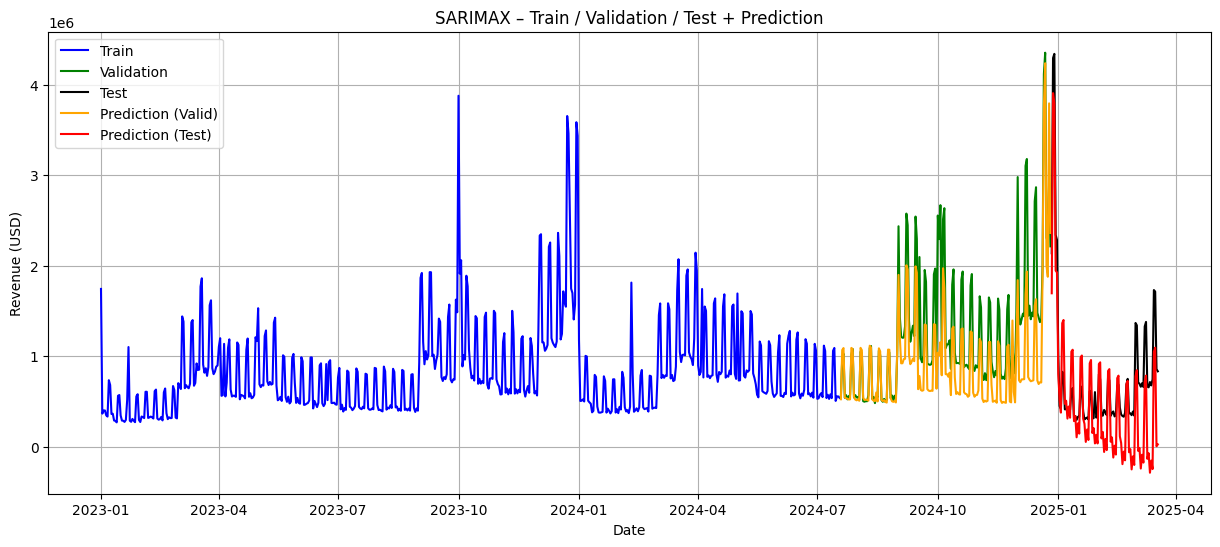

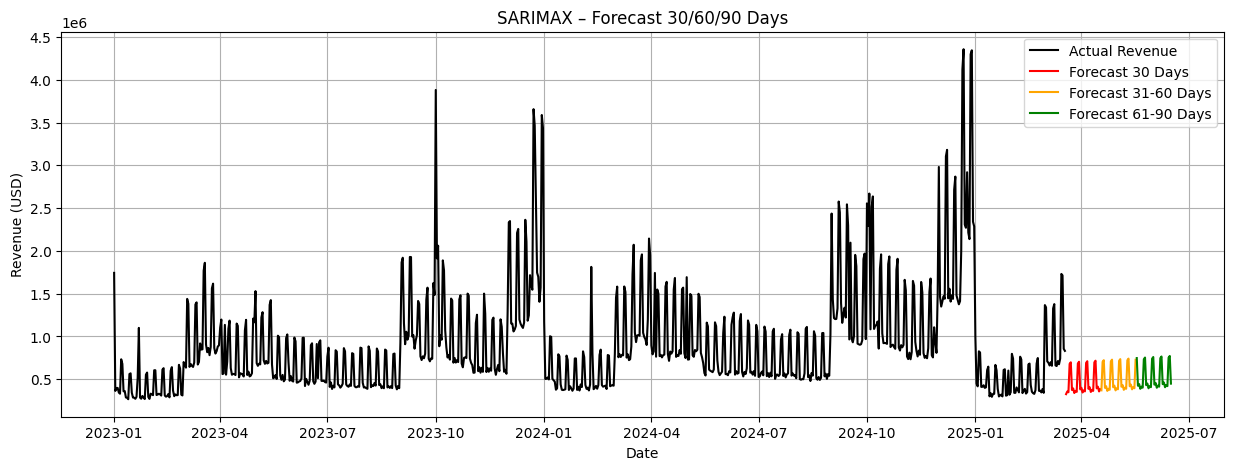

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# --- Chuẩn hóa dữ liệu ---
# Giả sử tx đã có index = 'Date' và cột 'Revenue_USD'
ts = tx['Revenue_USD'].resample('D').sum().fillna(0)
print("Dữ liệu aggregate (daily):")
print(ts.head(10))

# --- Tạo exogenous variables ---
tx['Promotion'] = np.random.randint(0,2,size=len(tx))
tx['Holiday']   = np.random.randint(0,2,size=len(tx))
exog = tx[['Promotion','Holiday']].resample('D').sum().fillna(0)
exog = exog.asfreq('D').fillna(0)

# --- Hàm sMAPE ---
def sMAPE(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denom)

# --- 5-Fold Time Series CV SARIMAX ---
def run_sarimax_cv(ts, exog, order=(1,1,1), seasonal_order=(1,1,1,7), n_splits=5):
    ts = ts.asfreq('D').fillna(0)
    n = len(ts)
    fold_size = n // n_splits
    results = []

    for i in range(n_splits):
        start = i * fold_size
        end   = start + fold_size if i < n_splits-1 else n

        fold_ts = ts[start:end]
        fold_exog = exog.iloc[start:end]

        n_fold = len(fold_ts)
        n_train = int(n_fold*0.7)
        n_valid = int(n_fold*0.2)
        n_test  = n_fold - n_train - n_valid

        train = fold_ts.iloc[:n_train]
        valid = fold_ts.iloc[n_train:n_train+n_valid]
        test  = fold_ts.iloc[n_train+n_valid:]

        exog_train = fold_exog.iloc[:n_train]
        exog_valid = fold_exog.iloc[n_train:n_train+n_valid]
        exog_test  = fold_exog.iloc[n_train+n_valid:]

        # Train SARIMAX trên train
        res_train = SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

        pred_valid = res_train.get_prediction(start=valid.index[0], end=valid.index[-1],
                                             dynamic=False, exog=exog_valid).predicted_mean

        # Train + Valid để dự đoán test
        ts_train_valid = pd.concat([train, valid])
        exog_train_valid = pd.concat([exog_train, exog_valid])
        res_full = SARIMAX(ts_train_valid, exog=exog_train_valid, order=order, seasonal_order=seasonal_order,
                           enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

        pred_test = res_full.get_prediction(start=test.index[0], end=test.index[-1],
                                           dynamic=False, exog=exog_test).predicted_mean

        mae_valid = mean_absolute_error(valid, pred_valid)
        smape_valid = sMAPE(valid.values, pred_valid.values)
        mae_test = mean_absolute_error(test, pred_test)
        smape_test = sMAPE(test.values, pred_test.values)

        results.append({
            "fold": i+1,
            "train": train,
            "valid": valid,
            "test": test,
            "pred_valid": pred_valid,
            "pred_test": pred_test,
            "metrics_valid": {"MAE": mae_valid, "sMAPE": smape_valid},
            "metrics_test": {"MAE": mae_test, "sMAPE": smape_test},
            "model_train_res": res_train,
            "model_full_res": res_full
        })
        print(f"Fold {i+1}: Valid sMAPE={smape_valid:.2f}, Test sMAPE={smape_test:.2f}")

    return results

# --- Chạy 5-fold CV ---
fold_results = run_sarimax_cv(ts, exog, order=(1,1,1), seasonal_order=(1,1,1,7))

# --- Train/Validation/Test và Prediction trên toàn bộ dữ liệu ---
n = len(ts)
n_train = int(n*0.7)
n_valid = int(n*0.2)
n_test  = n - n_train - n_valid

train = ts.iloc[:n_train]
valid = ts.iloc[n_train:n_train+n_valid]
test  = ts.iloc[n_train+n_valid:]

exog_train = exog.iloc[:n_train]
exog_valid = exog.iloc[n_train:n_train+n_valid]
exog_test  = exog.iloc[n_train+n_valid:]

res_train = SARIMAX(train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,7),
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_valid = res_train.get_prediction(start=valid.index[0], end=valid.index[-1],
                                     dynamic=False, exog=exog_valid).predicted_mean

ts_train_valid = pd.concat([train, valid])
exog_train_valid = pd.concat([exog_train, exog_valid])
res_full_train_valid = SARIMAX(ts_train_valid, exog=exog_train_valid, order=(1,1,1), seasonal_order=(1,1,1,7),
                               enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_test = res_full_train_valid.get_prediction(start=test.index[0], end=test.index[-1],
                                               dynamic=False, exog=exog_test).predicted_mean

# --- Forecast 30/60/90 ngày từ toàn bộ dữ liệu ---
res_full = SARIMAX(ts, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,7),
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

def forecast_future(model_res, exog_last, days):
    exog_future = pd.DataFrame({
        'Promotion': [1 if i%7 in [5,6] else 0 for i in range(days)],
        'Holiday': [0]*days
    })
    fc = model_res.get_forecast(steps=days, exog=exog_future)
    idx = pd.date_range(start=ts.index[-1]+pd.Timedelta(days=1), periods=days, freq='D')
    return pd.Series(fc.predicted_mean.values, index=idx)

fc30 = forecast_future(res_full, exog, 30)
fc60 = forecast_future(res_full, exog, 60)
fc90 = forecast_future(res_full, exog, 90)

# --- Vẽ Train / Validation / Test + Prediction liền mạch ---
plt.figure(figsize=(15,6))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(valid.index, valid, label="Validation", color="green")
plt.plot(test.index, test, label="Test", color="black")
plt.plot(pred_valid.index, pred_valid, label="Prediction (Valid)", color="orange")
plt.plot(pred_test.index, pred_test, label="Prediction (Test)", color="red")
plt.title("SARIMAX – Train / Validation / Test + Prediction")
plt.xlabel("Date")
plt.ylabel("Revenue (USD)")
plt.legend()
plt.grid(True)
plt.show()

# --- Vẽ Forecast 30/60/90 ngày ---
plt.figure(figsize=(15,5))
plt.plot(ts.index, ts, label="Actual Revenue", color="black")
plt.plot(fc30.index, fc30, label="Forecast 30 Days", color="red")
plt.plot(fc60.index[30:], fc60[30:], label="Forecast 31-60 Days", color="orange")
plt.plot(fc90.index[60:], fc90[60:], label="Forecast 61-90 Days", color="green")
plt.title("SARIMAX – Forecast 30/60/90 Days")
plt.xlabel("Date")
plt.ylabel("Revenue (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# =======================
# Define Metrics
# =======================
from sklearn.metrics import mean_absolute_error
import numpy as np

def MAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))


# =======================
# 1) Metrics – TRAIN
# =======================
pred_train = res_train.get_prediction(start=train.index[0],
                                      end=train.index[-1],
                                      dynamic=False).predicted_mean

mae_train = mean_absolute_error(train, pred_train)
rmse_train = RMSE(train, pred_train)
mape_train = MAPE(train, pred_train)


# =======================
# 2) Metrics – VALID
# =======================
mae_valid = mean_absolute_error(valid, pred_valid)
rmse_valid = RMSE(valid, pred_valid)
mape_valid = MAPE(valid, pred_valid)


# =======================
# 3) Metrics – TEST
# =======================
mae_test = mean_absolute_error(test, pred_test)
rmse_test = RMSE(test, pred_test)
mape_test = MAPE(test, pred_test)


# =======================
# 4) Metrics – FULL MODEL
#    (fit toàn bộ TS và dự đoán lại toàn bộ)
# =======================
full_pred = res_full.get_prediction(start=ts.index[0],
                                    end=ts.index[-1],
                                    dynamic=False).predicted_mean

mae_full = mean_absolute_error(ts, full_pred)
rmse_full = RMSE(ts, full_pred)
mape_full = MAPE(ts, full_pred)


# =======================
# PRINT RESULT
# =======================
print("\n================ SARIMA METRICS ================\n")
print(f"TRAIN  → MAE={mae_train:.2f}, RMSE={rmse_train:.2f}, MAPE={mape_train:.2f}%")
print(f"VALID  → MAE={mae_valid:.2f}, RMSE={rmse_valid:.2f}, MAPE={mape_valid:.2f}%")
print(f"TEST   → MAE={mae_test:.2f}, RMSE={rmse_test:.2f}, MAPE={mape_test:.2f}%")
print(f"FULL   → MAE={mae_full:.2f}, RMSE={rmse_full:.2f}, MAPE={mape_full:.2f}%")
print("\n===============================================\n")



================ SARIMA METRICS ================

TRAIN  → MAE=85595.62, RMSE=155977.74, MAPE=10.32%
VALID  → MAE=357690.98, RMSE=481149.24, MAPE=25.50%
TEST   → MAE=378524.05, RMSE=459813.37, MAPE=65.78%
FULL   → MAE=98364.47, RMSE=176869.31, MAPE=11.47%


